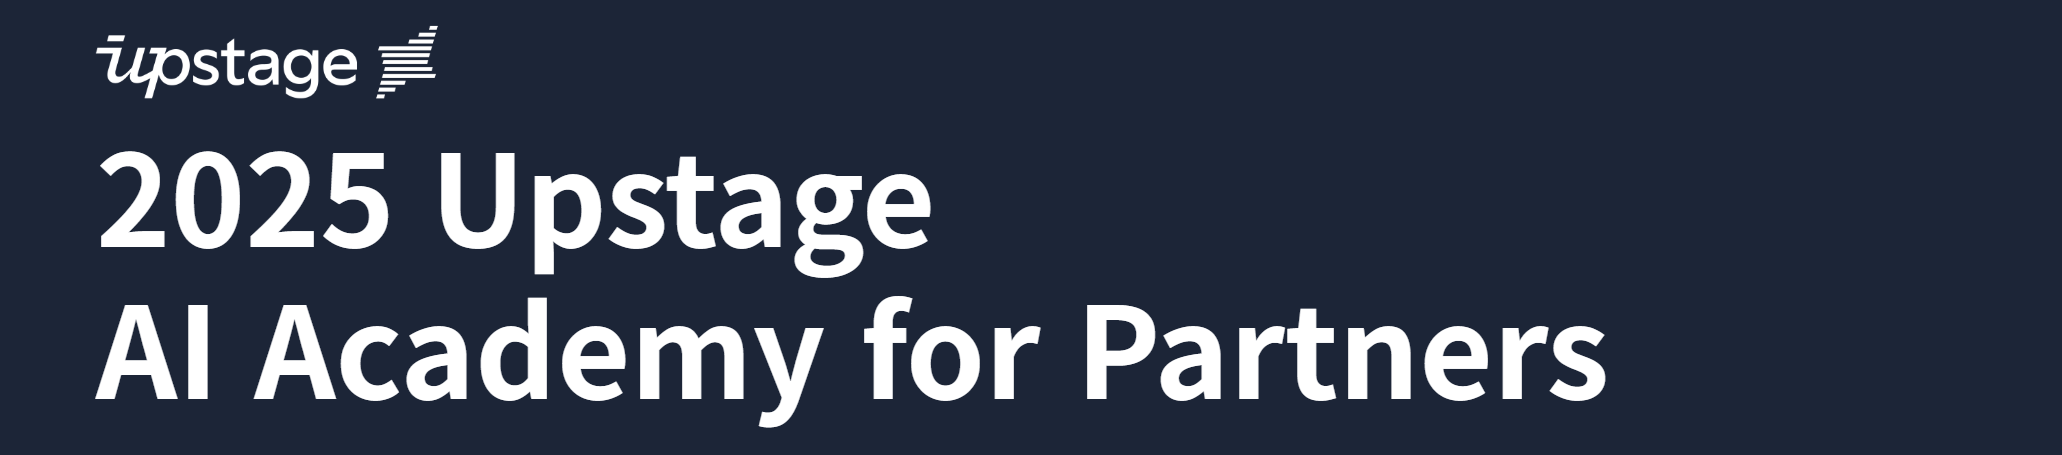

# **Document AI Hands On for Partners**

## **Overview**


이번 실습에서는 Upstage에서 개발한 Document AI 제품군 중 OCR 및 KIE 모델을 소개합니다. 이 노트북에서는 각 모델의 기본 설정 방법과 핵심 구성 요소를 살펴보고, 다양한 예제를 통해 주요 기능을 직접 실행해보며 이해도를 높이는 것을 목표로 합니다.

 #### **실습의 목적**
본 실습의 목적은 Upstage Document AI API 사용에 익숙해지도록 지원하는 것입니다.
튜토리얼을 완료한 후에는 사용자가 API를 활용해 Document AI 제품을 실행하는 기본적인 절차를 이해하게 되며, 이후 2분기 실습에서 다룰 보다 복잡한 작업 및 고급 활용을 위한 기반을 마련할 수 있습니다.
이번 1분기 실습은 다양한 문서 처리 상황에서 OCR 및 KIE 기능을 효과적으로 적용하기 위한 기초 역량을 쌓는 데 중점을 둡니다.

## **0. 환경 설정**

시작에 앞서 제공되는 실습을 위한 각종 환경 설정을 진행합니다. 순서는 다음과 같습니다.\
⚠️ 환경 설정에 어려움을 겪으시는 경우, 빠르게 주변 staff을 찾아주세요!

- 0.1 Google Drive Mount 하기
- 0.2 폴더 구조 및 이미지 준비하기
- 0.3 각종 라이브러리 설치하기
- 0.4 UPSTAGE_API_KEY 발급하기


### **0.1 Google Drive Mount 하기**
Google Drive에 배포된 폴더를 업로드 후 Colab환경에서 사용하기 위해 마운트를 진행합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **0.2 폴더 구조 및 이미지 준비하기**

파일이 잘 준비되었는지 확인하기 위해 폴더 구조를 확인합니다.

In [ ]:
import os

def print_tree(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # root_dir를 기준으로 몇 단계 아래에 있는지 계산
        level = dirpath.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}📁 {os.path.basename(dirpath)}/")
        for f in filenames:
            print(f"{indent}    📄 {f}")

# 원하는 폴더 경로로 수정
root_directory = r"/content/drive/MyDrive/HandsOn"   # 경로 필수 확인!!!!!
print_tree(root_directory)

### **0.3 각종 라이브러리 설치하기**

API 호출 및 실습 진행을 위한 각종 라이브러리를 설치합니다.

In [ ]:
# API 사용을 위해 필요
!pip install requests
!pip install rich
!pip install exifread
!pip install python-dotenv

### **0.4 UPSTAGE_API_KEY 발급하기**

Upstage API 키를 받으려면 다음 단계를 따라주세요:

1. Upstage AI 콘솔에 접속합니다. https://console.upstage.ai.

2. 계정이 없다면 회원가입을 합니다.

3. 계정에 로그인합니다.

4. API 키 섹션으로 이동합니다.

5. API 키를 생성합니다.

6. 생성된 키를 복사해 안전한 곳에 보관하세요.

⚠️ API key는 노출의 위험이 있으므로, 주기적으로 재발급을 진행하는 것이 좋습니다.

In [ ]:
from google.colab import userdata
os.environ["UPSTAGE_API_KEY"] = userdata.get("UPSTAGE_API_KEY")
api_key=os.environ["UPSTAGE_API_KEY"]

---

## **1.  OCR API 사용하기**
- 1.1 기본 API 호출 하기
- 1.2 기본 Output 구조 익히기
- 1.3 bbox 그리기 및 출력 순서 확인하기
- 1.4 Rotated, Watermarks, Noise, Checkboxes
- 1.5 DPI
- 1.6 Multi-pages

### **1.1 기본 API 호출 하기**

Upstage Document AI API 예제를 보고, 간단하게 OCR API를 호출해보겠습니다.  
이후 준비된 다양한 이미지 파일들을 OCR API 호출을 통해 처리해보겠습니다.

In [ ]:
# pip install requests

import requests
import os
from google.colab import userdata

filename = "drive/MyDrive/HandsOn/images/ocr/reciepts.jpg"

url = "https://api.upstage.ai/v1/document-digitization"
headers = {"Authorization": f"Bearer {api_key}"}

# model 파라미터에 "ocr"를 전달해 OCR 기능을 사용합니다.
files = {
    "document": open(filename, "rb"),
    "model": (None, "ocr")  # (None, "ocr") 형태로 명시
}

response = requests.post(url, headers=headers, files=files)
print(response.json())

In [ ]:
import os
import requests
import json
import time

SUPPORTED_EXTENSIONS = (
    '.jpg', '.jpeg',  # JPEG
    '.png',           # PNG
    '.bmp',           # BMP
    '.tif', '.tiff',  # TIFF
    '.pdf',           # PDF
    '.heic',          # HEIC
    '.docx',          # DOCX
    '.pptx',          # PPTX
    '.xlsx'           # XLSX
)

def save_ocr_result_with_retry(
    file_path,
    url,
    headers,
    output_file_path,
    max_retries=5,
    base_sleep_time=10
):
    """
    단일 파일에 대해 OCR API 호출 -> 결과 JSON 저장 과정을 수행하는 함수.
    429(too_many_requests) 에러가 발생하면
    일정 시간 대기 후 재시도합니다.

    Parameters
    ----------
    file_path : str
        OCR을 진행할 이미지 파일 경로
    url : str
        OCR API 엔드포인트 URL
    headers : dict
        OCR API에 필요한 헤더 정보 (e.g. {"Authorization": "Bearer ..."})
    output_file_path : str
        OCR 결과를 저장할 JSON 파일 경로
    max_retries : int, optional
        429 에러 발생 시 재시도할 최대 횟수
    base_sleep_time : int, optional
        재시도 시도 간 기본 대기 시간(초). 매 재시도 시 배수로 증가 가능.
    """
    # 재시도 횟수
    retry_count = 0

    while True:
        with open(file_path, "rb") as file:
            files = {"document": file}
            response = requests.post(url, headers=headers, files=files)

        # 응답 상태코드 확인
        if response.status_code == 429:  # Too Many Requests
            retry_count += 1
            if retry_count > max_retries:
                # print(f"[ERROR] 재시도 횟수 초과 (파일: {file_path})")
                return  # 혹은 raise Exception 등을 통해 에러 처리

            # 응답에 지정된 대기 시간이 있으면 쓰는 게 가장 좋음(예: response.headers["Retry-After"])
            # 없으면 base_sleep_time의 배수만큼 대기
            wait_time = base_sleep_time * retry_count
            # print(f"[WARNING] 429 Too Many Requests. {wait_time}초 후 재시도합니다. (재시도 {retry_count}/{max_retries})")
            time.sleep(wait_time)
            continue
        else:
            # JSON 파싱
            try:
                ocr_data = response.json()
            except json.JSONDecodeError:
                print(f"[ERROR] JSON 디코딩 실패 (파일: {file_path})")
                return

            # OCR API에서 에러 메시지가 왔는지 확인
            error_info = ocr_data.get("error", {})
            error_type = error_info.get("type", "")
            error_code = error_info.get("code", "")

            if error_type == "too_many_requests" or error_code == "too_many_requests":
                # 이 경우도 429와 동일하게 처리(대기 후 재시도)
                retry_count += 1
                if retry_count > max_retries:
                    # print(f"[ERROR] 재시도 횟수 초과 (파일: {file_path})")
                    return
                wait_time = base_sleep_time * retry_count
                # print(f"[WARNING] too_many_requests 에러. {wait_time}초 후 재시도합니다. (재시도 {retry_count}/{max_retries})")
                time.sleep(wait_time)
                continue
            else:
                # 정상 응답(혹은 다른 에러지만 429는 아님)이면 JSON 저장
                with open(output_file_path, "w", encoding="utf-8") as f:
                    json.dump(ocr_data, f, ensure_ascii=False, indent=4)
                # print("[INFO] OCR 결과 저장 완료:", output_file_path)
                return


def process_ocr_in_folder(root_ocr_img, root_ocr_json, url, headers, max_retries=5, base_sleep_time=10):
    """
    지정된 폴더 내 이미지 파일에 대하여 OCR을 진행하고,
    결과를 JSON으로 저장하는 함수입니다.
    429 에러가 발생할 경우 일정 시간 대기 후 재시도합니다.

    Parameters
    ----------
    root_ocr_img : str
        OCR 대상 이미지가 있는 폴더 경로
    root_ocr_json : str
        OCR 결과 JSON을 저장할 폴더 경로
    url : str
        OCR API 엔드포인트 URL
    headers : dict
        OCR API에 필요한 헤더 정보
    max_retries : int, optional
        429 에러 발생 시 재시도할 최대 횟수
    base_sleep_time : int, optional
        재시도 시도 간 기본 대기 시간(초). 매 재시도 시 배수로 증가 가능.
    """
    # 폴더 내 파일 순회
    for filename in os.listdir(root_ocr_img):
        # 이미지인지 확인
        if filename.lower().endswith(SUPPORTED_EXTENSIONS):
            file_path = os.path.join(root_ocr_img, filename)
            base_name = os.path.splitext(filename)[0]
            output_file_path = os.path.join(root_ocr_json, f"{base_name}.json")

            # print(f"[INFO] Processing: {file_path}")

            # OCR 결과 저장 (429 대응 재시도 포함)
            save_ocr_result_with_retry(
                file_path=file_path,
                url=url,
                headers=headers,
                output_file_path=output_file_path,
                max_retries=max_retries,
                base_sleep_time=base_sleep_time
            )
    print("End")

In [ ]:
root_ocr_img = r"drive/MyDrive/HandsOn/images/ocr"
root_ocr_json = r"drive/MyDrive/HandsOn/results/ocr"

url = "https://api.upstage.ai/v1/document-digitization"
headers = {"Authorization": f"Bearer {api_key}"}

process_ocr_in_folder(
    root_ocr_img=root_ocr_img,
    root_ocr_json=root_ocr_json,
    url=url,
    headers=headers,
    max_retries=5,        # 재시도 최대 5회
    base_sleep_time=10    # 기본 대기 시간 10초 (재시도 시 2배씩 증가)
)

### **1.2 기본 Output 구조 익히기**

results 폴더 하위에 결과물 json 파일을 통해 모델의 Output 구조를 확인하고, 해당 아웃풋 구조를 활용하는 방법을 익히겠습니다.

In [ ]:
from rich.tree import Tree
from rich import print
import json

def get_structure_fingerprint(data):
    """
    재귀적으로 딕셔너리(또는 리스트)의 key 구조에 대한 고유한 튜플 형태의 지문을 생성합니다.
    """
    if isinstance(data, dict):
        items = []
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                sub_fp = get_structure_fingerprint(value)
                items.append((key, sub_fp))
            else:
                items.append((key, None))
        # key 순서를 정렬하여 일관된 튜플을 생성합니다.
        return ("dict", tuple(sorted(items)))
    elif isinstance(data, list):
        if data:
            # 리스트의 첫 요소를 대표 구조로 사용
            return ("list", get_structure_fingerprint(data[0]))
        else:
            return ("list", None)
    else:
        return ("value", type(data).__name__)

def build_key_tree(data, tree, seen_fps):
    """
    data 내의 딕셔너리 key 구조를 rich의 Tree 객체에 추가합니다.
    이미 본 구조(fingerprint)는 중복 출력하지 않고 (repeated)로 표시합니다.
    """
    if isinstance(data, dict):
        # 현재 딕셔너리의 구조 지문 계산
        fp = get_structure_fingerprint(data)
        if fp in seen_fps:
            tree.add("[red](repeated)[/red]")
            return
        seen_fps.add(fp)
        for key, value in data.items():
            branch = tree.add(str(key))
            if isinstance(value, (dict, list)):
                build_key_tree(value, branch, seen_fps)
    elif isinstance(data, list):
        # 리스트의 경우 첫 요소만 대표 구조로 처리 (동일 구조가 반복될 가능성이 높으므로)
        if data and isinstance(data[0], (dict, list)):
            build_key_tree(data[0], tree, seen_fps)


In [ ]:
# JSON 파일 읽기 (파일 경로를 환경에 맞게 조정)
with open(r"drive/MyDrive/HandsOn/results/ocr/reciepts.json", "r", encoding="utf-8") as f:
    ocr_data = json.load(f)

# rich Tree 객체 생성
tree = Tree("JSON")
build_key_tree(ocr_data, tree, set())
print(tree)

### **1.3 bbox 그리기 및 출력 순서 확인하기**

출력물의 bbox를 이미지상에 그려봅니다.  
해당 시각화를 통해 좌상단에서 우하단으로 정보가 추출되는 것을 확인 합니다.
  
  serializer 의 동작을 이해하고 어떤 식으로 보정이 되어 결과가 나오는 지를 확인합니다.

In [ ]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def plot_side_by_side(json_path, img_path, mode="both", n_boxes=10):
    """
    한 화면에 좌우로 표시할지, 왼쪽 로직만 혹은 오른쪽 로직만 표시할지 모드를 선택할 수 있는 함수.
    표시할 박스 개수(n_boxes)도 인자로 받습니다.

    Parameters
    ----------
    json_path : str
        OCR 결과 JSON 파일 경로
    img_path : str
        원본 이미지 파일 경로
    mode : {"both", "left", "right"}, optional
        - "both": 좌/우 두 개의 그림(좌: y->x 정렬, 우: 순차 나열) 함께 표시 (기본값)
        - "left": 좌(=y->x 정렬) 그림만 표시
        - "right": 우(=순차 나열) 그림만 표시
    n_boxes : int, optional
        표시할 박스(Word)의 최대 개수 (기본값: 10)
    """
    # 1) JSON 로드
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 2) 이미지 로드
    img = plt.imread(img_path)

    # OCR 정보
    page = data["pages"][0]
    words = page["words"]

    # 보여줄 word 개수
    subset = words[:n_boxes]

    # 공통적으로 사용할 컬러맵
    cmap = plt.get_cmap("tab20")

    # -------------------------------------------
    # 모드별로 분기
    # -------------------------------------------
    if mode == "both":
        # ---------------------------
        # 1행 2열 서브플롯 생성
        # ---------------------------
        fig, axes = plt.subplots(1, 2, figsize=(24, 9))

        # ====== [왼쪽: y->x 정렬] ======
        ax_left = axes[0]
        ax_left.imshow(img)
        # y좌표의 최솟값 기준 정렬
        sorted_words_yx = sorted(subset, key=lambda w: min(v["y"] for v in w["boundingBox"]["vertices"]))
        for idx, word in enumerate(sorted_words_yx):
            vertices = word["boundingBox"]["vertices"]
            points = [(v["x"], v["y"]) for v in vertices]

            poly = Polygon(points, closed=True, edgecolor=cmap(idx), facecolor='none', linewidth=2)
            ax_left.add_patch(poly)
            ax_left.text(points[0][0], points[0][1] - 5, str(idx), color=cmap(idx), fontsize=12)

        ax_left.set_title("plot_ocr_boxes_y_x (left)")
        ax_left.axis("off")

        # ====== [오른쪽: 순차 나열] ======
        ax_right = axes[1]
        ax_right.imshow(img)
        for idx, word in enumerate(subset):
            vertices = word["boundingBox"]["vertices"]
            points = [(v["x"], v["y"]) for v in vertices]

            poly = Polygon(points, closed=True, edgecolor=cmap(idx), facecolor='none', linewidth=2)
            ax_right.add_patch(poly)
            ax_right.text(points[0][0], points[0][1] - 5, str(idx), color=cmap(idx), fontsize=12)

        ax_right.set_title("plot_ocr_boxes_serialize (right)")
        ax_right.axis("off")

        plt.show()

    elif mode == "left":
        # ---------------------------
        # y->x 정렬 로직만 단독으로 표시
        # ---------------------------
        fig, ax = plt.subplots(figsize=(12, 9))
        ax.imshow(img)

        sorted_words_yx = sorted(subset, key=lambda w: min(v["y"] for v in w["boundingBox"]["vertices"]))
        for idx, word in enumerate(sorted_words_yx):
            vertices = word["boundingBox"]["vertices"]
            points = [(v["x"], v["y"]) for v in vertices]

            poly = Polygon(points, closed=True, edgecolor=cmap(idx), facecolor='none', linewidth=2)
            ax.add_patch(poly)
            ax.text(points[0][0], points[0][1] - 5, str(idx), color=cmap(idx), fontsize=12)

        ax.set_title("plot_ocr_boxes_y_x (only)")
        ax.axis("off")
        plt.show()

    elif mode == "right":
        # ---------------------------
        # 순차 나열 로직만 단독으로 표시
        # ---------------------------
        fig, ax = plt.subplots(figsize=(12, 9))
        ax.imshow(img)

        for idx, word in enumerate(subset):
            vertices = word["boundingBox"]["vertices"]
            points = [(v["x"], v["y"]) for v in vertices]

            poly = Polygon(points, closed=True, edgecolor=cmap(idx), facecolor='none', linewidth=2)
            ax.add_patch(poly)
            ax.text(points[0][0], points[0][1] - 5, str(idx), color=cmap(idx), fontsize=12)

        ax.set_title("plot_ocr_boxes_serialize (only)")
        ax.axis("off")
        plt.show()

    else:
        raise ValueError("mode 파라미터는 'both', 'left', 'right' 중 하나여야 합니다.")




In [ ]:
# OCR 결과 JSON 파일 경로
json_path = os.path.join(root_ocr_json, "reciepts.json")
# 원본 이미지 파일 경로
img_path = os.path.join(root_ocr_img, "reciepts.jpg")
plot_side_by_side(json_path,img_path)

### **1.4 Rotated, Watermarks, Noise, Checkboxes**

업스테이지 모델이 지원하는 Rotated, Watermarks, Noise, Checkboxes 들의 명확한 범위를 알아봅니다.


*   Rotated - 0 ~ 360도 전부 지원, 검출 및 인식 보장, 추출 순서는 보장하지 않음
*   Watermarks - 워터마크와 일반 텍스트가 겹치는 경우 일반 텍스트 우선 검출
*   Noise - 조명변화, 종이 텍스처나 색상변화, 팩스 노이즈등 visual noise
*   Checkboxes - 대부분의 v로 표시되는 체크 영역



In [ ]:
# OCR 결과 JSON 파일 경로
json_path = os.path.join(root_ocr_json, "rotate.json")
# 원본 이미지 파일 경로
img_path = os.path.join(root_ocr_img, "rotate.jpg")
plot_side_by_side(json_path,img_path, mode='right')

In [ ]:
# OCR 결과 JSON 파일 경로
json_path = os.path.join(root_ocr_json, "water_mark.json")
# 원본 이미지 파일 경로
img_path = os.path.join(root_ocr_img, "water_mark.jpg")
plot_side_by_side(json_path,img_path, mode='right',n_boxes=100 )

In [ ]:
# OCR 결과 JSON 파일 경로
json_path = os.path.join(root_ocr_json, "check_box.json")
# 원본 이미지 파일 경로
img_path = os.path.join(root_ocr_img, "check_box.png")
plot_side_by_side(json_path,img_path, mode='right',n_boxes=100 )

### **1.5 DPI**

DPI에 따른 출력 결과물의 차이를 확인해 봅니다.
  
  Upstage의 모델은 기본 150 dpi를 default로 권장하고 있습니다.
  
  또한 OCR 모델의 경우는 225이상 에서 모든 사이즈의 font에서 성능을 보장하고 있습니다.

In [ ]:
# OCR 결과 JSON 파일 경로
json_path = os.path.join(root_ocr_json, "dpi_75.json")
# 원본 이미지 파일 경로
img_path = os.path.join(root_ocr_img, "dpi_75.jpg")
plot_side_by_side(json_path,img_path, mode='right',n_boxes=100 )

In [ ]:
# OCR 결과 JSON 파일 경로
json_path = os.path.join(root_ocr_json, "dpi_150.json")
# 원본 이미지 파일 경로
img_path = os.path.join(root_ocr_img, "dpi_150.jpg")
plot_side_by_side(json_path,img_path, mode='right',n_boxes=100 )

### **1.6 Multi-pages**

PDF 멀티페이지 기능을 지원하고 있습니다.
  
  최대 30 pages 까지 지원이 가능합니다.

In [ ]:
import json

def count_pages_in_json(json_path):
    """
    주어진 JSON 파일을 읽고,
    'pages' 키 안에 몇 개의 리스트 원소가 있는지 확인한 뒤, 개수를 반환.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 'pages' 키가 존재하는지 확인, 없으면 빈 리스트로 대체
    pages = data.get("pages", [])

    # pages가 list 형태라 가정하고 길이(개수) 확인
    num_pages = len(pages)
    print(f"'page 수: {num_pages}")

In [ ]:
json_file_path = "drive/MyDrive/HandsOn/results/ocr/multi_page.json"  # 실제 JSON 경로
count_pages_in_json(json_file_path)

## **2.  KIE API 사용하기 (Prebuilt information extraction)**
- 2.1 기본 API 호출 하기
- 2.2 기본 Output 구조 익히기
- 2.3 각 모델들의 추출 가능한 값들 확인

### **2.1 기본 API 호출 하기**

KIE API 모델의 종류를 알아보고, 해당 모델들을 API를 통해 호출하고 사용하는 방법을 배웁니다.

In [ ]:
# 모델 종류
receipt = "receipt-extraction"
air_waybil = "air-waybill-extraction"
bill_of_lading = "bill-of-lading-and-shipping-request-extraction"
commercial_invoice = "commercial-invoice-and-packing-list-extraction"
certificate = "kr-export-declaration-certificate-extraction"


In [ ]:
# pip install requests

import requests
import os
from google.colab import userdata
OUTPUT_JSON_PATH = "drive/MyDrive/HandsOn/results/kie/receipts.json"
filename = "drive/MyDrive/HandsOn/images/ocr/reciepts.jpg"
model = receipt

url = f"https://api.upstage.ai/v1/information-extraction"
headers = {"Authorization": f"Bearer {api_key}"}

# model 파라미터에 "ocr"를 전달해 OCR 기능을 사용합니다.
files = {
    "document": open(filename, "rb"),
    "model": (None, "receipt-extraction")  # (None, "ocr") 형태로 명시
}

response = requests.post(url, headers=headers, files=files)
data = response.json()
with open(OUTPUT_JSON_PATH, "w", encoding="utf-8") as f:
  json.dump(data, f, ensure_ascii=False, indent=4)

### **2.2 기본 Output 구조 익히기**

KIE 모델의 output 구조를 딥하게 학습합니다.
  
  반복되는 딕셔너리 구조의 key값들의 차이를 정확히 인지합니다.
  
  필요한 값들을 정확하게 찾아 낼 수 있도록 구조를 이해할 수 있습니다.

In [ ]:
# JSON 파일 읽기 (파일 경로를 환경에 맞게 조정)
with open(r"drive/MyDrive/HandsOn/results/kie/receipts.json", "r", encoding="utf-8") as f:
    ocr_data = json.load(f)

# rich Tree 객체 생성
tree = Tree("JSON")
build_key_tree(ocr_data, tree, set())
print(tree)

### **2.3 각 모델들의 추출 가능한 값들을 확인하는 법**

https://console.upstage.ai/docs/models 접속
  
  각 사용하고자 하는 모델의 feild_description 확인

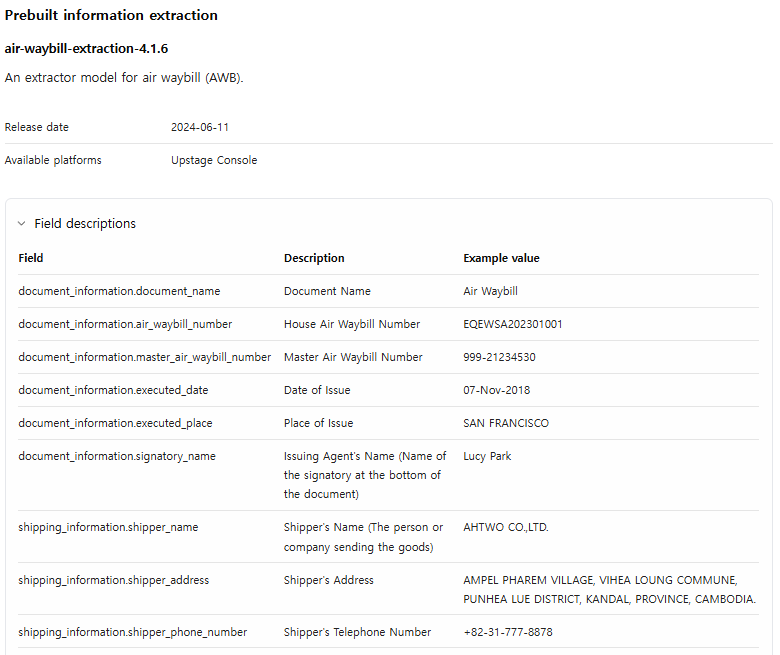

## 콘텐츠 라이선스

<hr style="height:5px;border:none;color:#5F71F7;background-color:#5F71F7">

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있습니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다. </b>